## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Reading datasets

In [2]:
ds_chromecast = pd.read_csv('./Docs/dataset_chromecast.csv')
print(ds_chromecast.shape)
ds_smart_tv = pd.read_csv('./Docs/dataset_smart-tv.csv')
print(ds_smart_tv.shape)

(1620529, 4)
(4417903, 4)


## Utility Functions

### Part 2 Utility Functions

#### Rescaling

In [3]:
def add_one(df, col):
    df[col] = df[col] + 1
    return df

In [4]:
def transform_log10(df, col):
    df[col] = np.log10(df[col])
    return df

In [5]:
def add_one_and_transform_log10(df, col):
    df = add_one(df, col)
    df = transform_log10(df, col)
    return df

#### Plotting

In [6]:
def sturges_rule(df):
    n = df.shape[0]
    sr = 1 + 3.3 * np.log10(n)
    return sr

In [7]:
def gen_histogram(df, col, plot_title, stat='count'):
    sns.set(rc={'figure.figsize':(5,3)})
    bins = int(sturges_rule(df))
    sns.histplot(data=df, x=col, bins=bins, stat=stat)
    plt.title(plot_title)

In [8]:
def gen_ecdf(df, col, plot_title):
    sns.set(rc={'figure.figsize':(5,3)})
    sns.ecdfplot(data=df, x=col)
    plt.title(plot_title)

In [9]:
def gen_boxplot(df, col, plot_title):
    sns.set(rc={'figure.figsize':(5,3)})
    sns.boxplot(data=df, x=col)
    plt.title(plot_title)

### Part 3 Utility Functions

#### Generating basic statistics

In [10]:
def gen_basic_stats(df):
    basic_stats = df[['bytes_up', 'bytes_down']].describe().loc[['mean', 'std']]
    basic_stats.loc['variance'] = basic_stats.loc['std']**2
    basic_stats.rename({'std': 'std_dev'}, inplace=True)
    return basic_stats

#### Per hour analysis

In [11]:
def type_to_datetime(df):
    df['date_hour'] = pd.to_datetime(df['date_hour'], infer_datetime_format=True)
    return df

In [12]:
def slicing_data_per_hour(df):
    hours = [i for i in range(0, 24)]
    sliced_data = dict()
    for hour in hours:
        time_mask = (df['date_hour'].dt.hour >= int(hour)) & \
                (df['date_hour'].dt.hour < int(hour)+1)
        sliced_data[hour] = df[time_mask]
    return sliced_data

In [13]:
def gen_per_time_boxplots(df, col, ds_name):
    for i in range(0, 6):

        fig, axs = plt.subplots(nrows=4, figsize=(8, 6))
        plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, wspace=1.2, hspace=1.2)
        fig.suptitle(f'{ds_name} per hour boxplots')

        sns.boxplot(df[i*4], x=col, ax=axs[0])
        axs[0].set_title(f'Chromecast {col} {i*4} hours')
        sns.boxplot(df[i*4+1], x=col, ax=axs[1])
        axs[1].set_title(f'Chromecast {col} {i*4+1} hours')
        sns.boxplot(df[i*4+2], x=col, ax=axs[2])
        axs[2].set_title(f'Chromecast {col} {i*4+2} hours')
        sns.boxplot(df[i*4+3], x=col, ax=axs[3])
        axs[3].set_title(f'Chromecast {col} {i*4+3} hours')

In [14]:
def gen_per_time_basic_stats(df, col, ds_name):
    hours = [i for i in range(0, 24)]
    for hour in hours:
        print(f'{ds_name} {col} basic stats {hour} hours')
        ds_df_sliced_basic_stats = gen_basic_stats(df[hour])
        print(ds_df_sliced_basic_stats[col])
        print('\n')

In [15]:
def gen_stats_dict():
    stats_dict = {
        'bytes_up_mean': [], 'bytes_up_std_dev': [], 'bytes_up_var': [],
        'bytes_down_mean': [], 'bytes_down_std_dev': [], 'bytes_down_var': []
    }
    return stats_dict

In [16]:
def gen_df_dict_basic_stats(df):
    df_basic_stats_dict = gen_stats_dict()

    for i in range(0, 24):
        ds_hour = df[i]
        df_basic_stats = ds_hour[['bytes_up', 'bytes_down']].describe().loc[['mean', 'std']]

        bytes_up_mean_sample = df_basic_stats['bytes_up'][0]
        bytes_up_std_dev_sample = df_basic_stats['bytes_up'][1]

        bytes_down_mean_sample = df_basic_stats['bytes_down'][0]
        bytes_down_std_dev_sample = df_basic_stats['bytes_down'][1]

        df_basic_stats_dict['bytes_up_mean'].append(bytes_up_mean_sample)
        df_basic_stats_dict['bytes_up_std_dev'].append(bytes_up_mean_sample)

        df_basic_stats_dict['bytes_down_mean'].append(bytes_down_mean_sample)
        df_basic_stats_dict['bytes_down_std_dev'].append(bytes_down_mean_sample)

    df_basic_stats_dict['bytes_up_var'] = [i**2 for i in df_basic_stats_dict['bytes_up_std_dev']]
    df_basic_stats_dict['bytes_down_var'] = [i**2 for i in df_basic_stats_dict['bytes_down_std_dev']]

    return df_basic_stats_dict

In [17]:
def gen_df_basic_stats(df_dict):
    df_basic_stats = pd.DataFrame(
        {
            'bytes_up_mean': df_dict['bytes_up_mean'],
            'bytes_up_std_dev': df_dict['bytes_up_std_dev'],
            'bytes_up_var': df_dict['bytes_up_var'],
            'bytes_down_mean': df_dict['bytes_down_mean'],
            'bytes_down_std_dev': df_dict['bytes_down_std_dev'],
            'bytes_down_var': df_dict['bytes_down_var'],
        }
    )
    return df_basic_stats

### Part 4 Utility Functions

#### Generating datasets

In [18]:
def extend_df_dict_with_median(df, df_dict):
    bytes_up_medians = []
    bytes_down_medians = []
    for i in range(0, 24):
        ds_hour = df[i]

        bytes_up_median = ds_hour['bytes_up'].median()
        bytes_down_median = ds_hour['bytes_down'].median()

        bytes_up_medians.append(bytes_up_median)
        bytes_down_medians.append(bytes_down_median)
    df_dict['bytes_up_median'] = bytes_up_medians
    df_dict['bytes_down_median'] = bytes_down_medians

In [19]:
def hour_with_highest_mean(df_dict):
    sorted_bytes_up_means = sorted(df_dict['bytes_up_mean'], reverse=True)
    sorted_bytes_down_means = sorted(df_dict['bytes_down_mean'], reverse=True)

    highest_bytes_up_means = sorted_bytes_up_means[0]
    highest_bytes_down_means = sorted_bytes_down_means[0]

    bytes_up_idx = df_dict['bytes_up_mean'].index(highest_bytes_up_means)
    bytes_down_idx = df_dict['bytes_down_mean'].index(highest_bytes_down_means)

    return bytes_up_idx, bytes_down_idx

In [20]:
def hour_with_highest_median(df_dict):
    sorted_bytes_up_medians = sorted(df_dict['bytes_up_median'], reverse=True)
    sorted_bytes_down_medians = sorted(df_dict['bytes_down_median'], reverse=True)

    highest_bytes_up_medians = sorted_bytes_up_medians[0]
    highest_bytes_down_medians = sorted_bytes_down_medians[0]

    bytes_up_idx = df_dict['bytes_up_median'].index(highest_bytes_up_medians)
    bytes_down_idx = df_dict['bytes_down_median'].index(highest_bytes_down_medians)

    return bytes_up_idx, bytes_down_idx

#### Calculating MLE

In [21]:
from scipy import stats
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
np.random.seed(1)

In [22]:
def calculate_mle_gaussian(df, col):
    sample_data = df[col].values
    mle = stats.norm.fit(sample_data)
    return mle

In [23]:
def calculate_mle_gamma(df, col):
    sample_data = df[col].values
    mle = stats.gamma.fit(sample_data)
    return mle

In [24]:
def calculate_mle_all_dfs(dfs, kind):
    dfs_mle = {i:[] for i in range(1, 9)}
    cols = ['bytes_up', 'bytes_up', 'bytes_down', 'bytes_down',
            'bytes_up', 'bytes_up', 'bytes_down', 'bytes_down'
    ]
    if kind == 'gaussian':
        for i in range(0, 8):
            dfs_mle[i+1] = calculate_mle_gaussian(dfs[i], cols[i])
    if kind == 'gamma':
        for i in range(0, 8):
            dfs_mle[i+1] = calculate_mle_gamma(dfs[i], cols[i])
    return dfs_mle

#### Plotting histogram and MLE curves

In [25]:
def plotting_hist_mle_curves(dfs, dfs_gaussian_mle, dfs_gamma_mle, i):
    device_name = ['Chromecast', 'Chromecast', 'Chromecast', 'Chromecast',
                    'Smart TV', 'Smart TV', 'Smart TV', 'Smart TV'
    ]
    cols = ['bytes_up', 'bytes_up', 'bytes_down', 'bytes_down',
            'bytes_up', 'bytes_up', 'bytes_down', 'bytes_down'
    ]
    gen_histogram(dfs[i-1], cols[i-1], f'Dataset {i}', stat='density')

    max_val = int(np.floor(dfs[i-1][cols[i-1]].max()))

    x = np.arange(0, max_val, 0.001)

    mu = dfs_gaussian_mle[1][0]
    sigma = dfs_gaussian_mle[1][1]

    plt.plot(x, stats.norm.pdf(x, mu, sigma))

    shape = dfs_gamma_mle[1][0]
    loc = dfs_gamma_mle[1][1]
    scale = dfs_gamma_mle[1][2]

    plt.plot(x, stats.gamma.pdf(x, shape, loc, scale))
    plt.legend(['gaussian', 'gamma'])

#### Plotting probability plots

In [26]:
def gen_probability_plot_mle(dfs, dfs_gaussian_mle, i):
    device_name = ['Chromecast', 'Chromecast', 'Chromecast', 'Chromecast',
                    'Smart TV', 'Smart TV', 'Smart TV', 'Smart TV'
    ]
    cols = ['bytes_up', 'bytes_up', 'bytes_down', 'bytes_down',
            'bytes_up', 'bytes_up', 'bytes_down', 'bytes_down'
    ]

    vals = dfs[i-1][cols[i-1]].values
    min_val = min(vals)
    max_val = max(vals)
    fig, ax = plt.subplots(figsize=(6, 3))

    res = stats.probplot(vals, sparams=dfs_gaussian_mle[i], dist='norm', plot=ax)
    plt.xlim(min_val, max_val)
    plt.title(f'Dataset {i} Probability Plot')

In [27]:
def gen_probability_plot_mle(dfs, dfs_gamma_mle, i):
    device_name = ['Chromecast', 'Chromecast', 'Chromecast', 'Chromecast',
                    'Smart TV', 'Smart TV', 'Smart TV', 'Smart TV'
    ]
    cols = ['bytes_up', 'bytes_up', 'bytes_down', 'bytes_down',
            'bytes_up', 'bytes_up', 'bytes_down', 'bytes_down'
    ]

    vals = dfs[i-1][cols[i-1]].values
    min_val = min(vals)
    max_val = max(vals)
    fig, ax = plt.subplots(figsize=(6, 3))

    res = stats.probplot(vals, sparams=dfs_gamma_mle[i], dist='gamma', plot=ax)
    plt.xlim(min_val, max_val)
    plt.title(f'Dataset {i} Probability Plot')

### Part 5 Utility Functions

#### Correlation analysis

In [28]:
def get_same_time_datasets(df1, df2, sliced_df):
    df1_mod = df1
    df2_mod = df2

    hour1 = df1['date_hour'].head(1).dt.hour.values[0]
    hour2 = df2['date_hour'].head(1).dt.hour.values[0]

    if hour1 != hour2:
        df1_mod = sliced_df[hour2]

    return df1_mod, df2_mod

In [29]:
def calculate_coefficient_correlation(df1, df2):
    time_mask = df1['date_hour'] == df2['date_hour']

    df1_corr = df1[time_mask]
    df2_corr = df2[time_mask]

    cols = ['bytes_up', 'bytes_down']
    corr_coefs = df1_corr[cols].corrwith(df2_corr[cols], axis=0)
    return corr_coefs

### Part 6 Utility Functions

#### G-Test

In [30]:
def gen_g_test_histogram(df1, df2, col):
    n = int(sturges_rule(df1))
    
    vals1 = df1[col].values
    vals2 = df2[col].values

    hist1 = np.histogram(vals1, bins=n)
    hist2 = np.histogram(vals2, bins=n)

    return hist1, hist2

In [31]:
def calculate_g_test(observed, expected):
    observed_vals = np.array(observed[0])
    observed_vals_norm = observed_vals / observed_vals.sum()
    
    expected_vals = np.array(expected[0])
    expected_vals_norm = expected_vals / expected_vals.sum()

    g, p = stats.power_divergence(observed_vals_norm, expected_vals_norm, lambda_='log-likelihood')
    return g, p

## 2. Analysing datasets - General statistics

### Seeing some observations

In [32]:
ds_chromecast.head()

,device_id,date_hour,bytes_up,bytes_down
0,66161985,2021-09-06 00:01:00,2987.016393,49185.704918
1,66161985,2021-09-06 00:02:00,685.935484,328.258065
2,66161985,2021-09-06 00:03:00,4493.901639,37914.064516
3,66161985,2021-09-06 00:04:00,776.133333,229.200000
4,66161985,2021-09-06 00:05:00,3081.311475,51656.800000


In [33]:
ds_smart_tv.head()

,device_id,date_hour,bytes_up,bytes_down
0,77209603,2021-11-22 15:23:00,132932.983607,2.818140e+06
1,77209603,2021-11-22 15:24:00,115770.491803,2.264410e+06
2,77209603,2021-11-22 15:25:00,114030.032787,2.309270e+06
3,77209603,2021-11-22 15:26:00,97170.622951,2.006544e+06
4,77209603,2021-11-22 15:27:00,39569.573770,8.061440e+05


### Rescaling to base log 10

In [34]:
ds_chromecast = add_one_and_transform_log10(ds_chromecast, 'bytes_up')
ds_chromecast = add_one_and_transform_log10(ds_chromecast, 'bytes_down')

ds_smart_tv = add_one_and_transform_log10(ds_smart_tv, 'bytes_up')
ds_smart_tv = add_one_and_transform_log10(ds_smart_tv, 'bytes_down')

### Plotting histograms

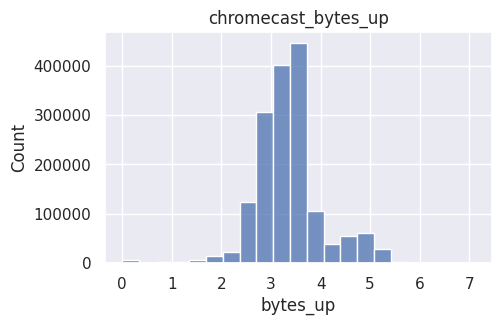

In [35]:
gen_histogram(ds_chromecast, 'bytes_up', 'chromecast_bytes_up')

Podemos observar que o histograma gerado assemelha-se a uma distribuição normal skewed para a direita.

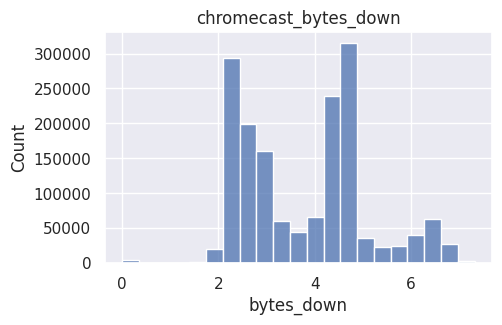

In [36]:
gen_histogram(ds_chromecast, 'bytes_down', 'chromecast_bytes_down')

Podemos observar que o histograma gerado não se assemelha à alguma distribuição conhecida da literatura. Além disso, temos que a maior parte das amostras encontra-se no intervalo de 0,4 à 0,9.

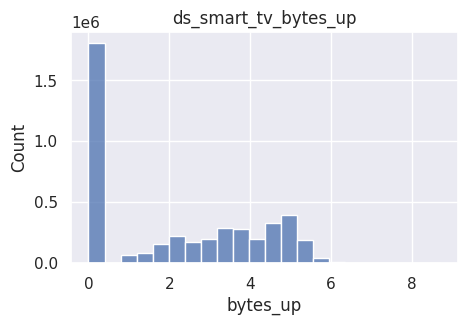

In [37]:
gen_histogram(ds_smart_tv, 'bytes_up', 'ds_smart_tv_bytes_up')

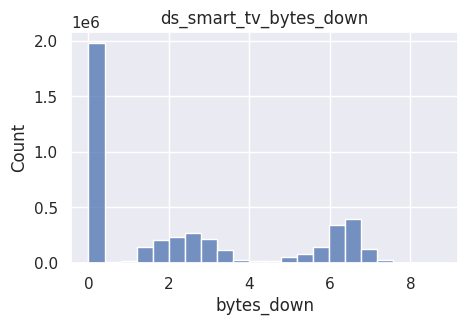

In [38]:
gen_histogram(ds_smart_tv, 'bytes_down', 'ds_smart_tv_bytes_down')

### Plotting empirical cumulative distributions

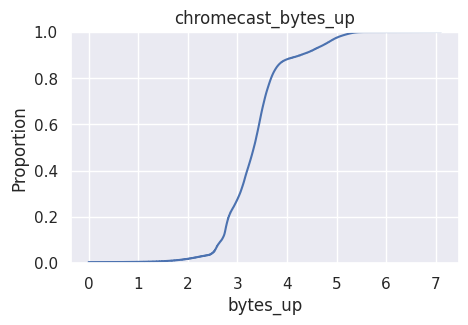

In [39]:
gen_ecdf(ds_chromecast, 'bytes_up', 'chromecast_bytes_up')

Podemos observar que a probabilidade de ao realizar uma observação obtermos um valor de taxa de upload abaixo de 0,5 é bem próxima de 0. Além disso, podemos observar que a probabilidade de encontrar uma amostra com uma taxa de upload entre 0.5 e 0.8 é bem próxima de 1.

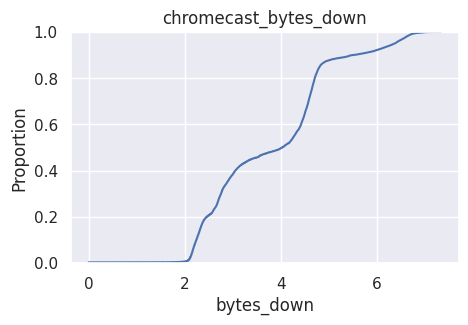

In [40]:
gen_ecdf(ds_chromecast, 'bytes_down', 'chromecast_bytes_down')

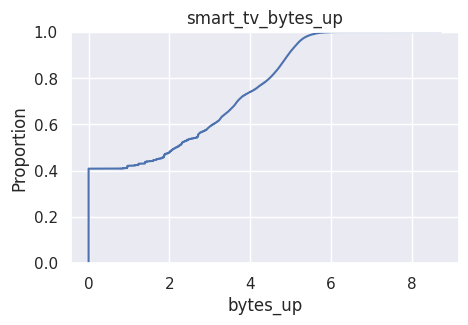

In [41]:
gen_ecdf(ds_smart_tv, 'bytes_up', 'smart_tv_bytes_up')

Podemos observar que a probabilidade de ao realizar uma observação obtermos um valor de taxa de upload abaixo de 0,5 é bem próxima de 0. Além disso, podemos observar que a probabilidade de encontrar uma amostra com uma taxa de upload entre 0.5 e 0.8 é bem próxima de 1.

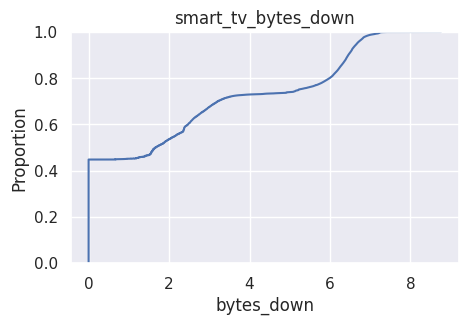

In [42]:
gen_ecdf(ds_smart_tv, 'bytes_down', 'smart_tv_bytes_down')

### Plotting boxplots

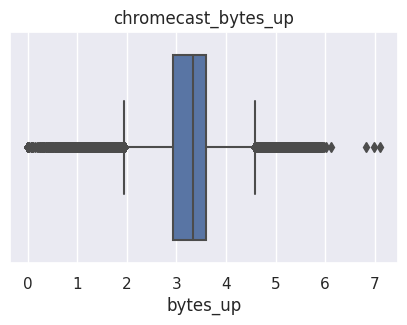

In [43]:
gen_boxplot(ds_chromecast, 'bytes_up', 'chromecast_bytes_up')

Podemos observar que o intervalo de 25% percentil a 75% percentil é um intervalo bem estreito com relação a taxa de upload, sendo cerca de 5,8 à 6,5. Além disso, temos uma aparente grande quantidade de outliers.

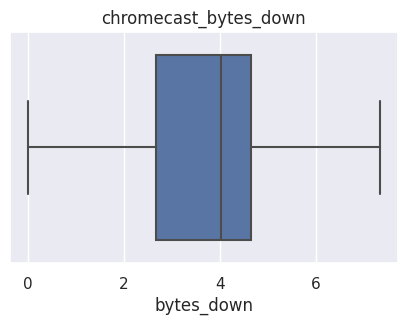

In [44]:
gen_boxplot(ds_chromecast, 'bytes_down', 'chromecast_bytes_down')

Podemos observar que o intervalo de 25% percentil a 75% percentil para esse conjunto de dados tratando-se da taxa de download é mais largo que tratando-se da taxa de upload, sendo cerca de 5,8 à 6,8. Há também uma aparente grande quantidade de outliers.

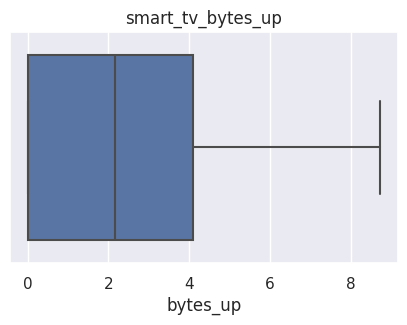

In [45]:
gen_boxplot(ds_smart_tv, 'bytes_up', 'smart_tv_bytes_up')

Podemos observar que o intervalo de 25% percentil a 75% percentil é um intervalo bem estreito com relação a taxa de upload, sendo cerca de 5,8 à 6,5. Além disso, temos uma aparente grande quantidade de outliers.

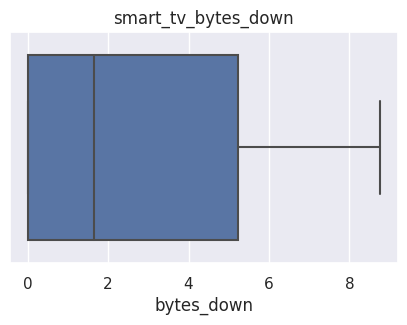

In [46]:
gen_boxplot(ds_smart_tv, 'bytes_down', 'smart_tv_bytes_down')

Podemos observar que o intervalo de 25% percentil a 75% percentil para esse conjunto de dados tratando-se da taxa de download é mais largo que tratando-se da taxa de upload, sendo cerca de 5,8 à 6,8. Há também uma aparente grande quantidade de outliers.

### Calculating basic statistics

In [47]:
ds_chromecast_basic_stats = gen_basic_stats(ds_chromecast)
print(ds_chromecast_basic_stats)

          bytes_up  bytes_down
mean      3.350300    3.800046
std_dev   0.678210    1.289921
variance  0.459969    1.663896


In [48]:
ds_smart_tv_basic_stats = gen_basic_stats(ds_smart_tv)
print(ds_smart_tv_basic_stats)

          bytes_up  bytes_down
mean      2.158288    2.351679
std_dev   2.027348    2.592552
variance  4.110139    6.721324


Podemos observar que ambos os dispositivos possuem valores idênticos de média, desvio padrão e variância, o que pode indicar que as taxas de upload e download não dependem do dispositivo em questão.

## 3. Analysing datasets - Per time statistics

### Transforming type to datetime and slicing data

In [49]:
ds_chromecast = type_to_datetime(ds_chromecast)
ds_smart_tv = type_to_datetime(ds_smart_tv)

In [50]:
ds_chromecast_sliced = slicing_data_per_hour(ds_chromecast)
ds_smart_tv_sliced = slicing_data_per_hour(ds_smart_tv)

### Chromecast bytes up

#### Boxplots Chromecast bytes up

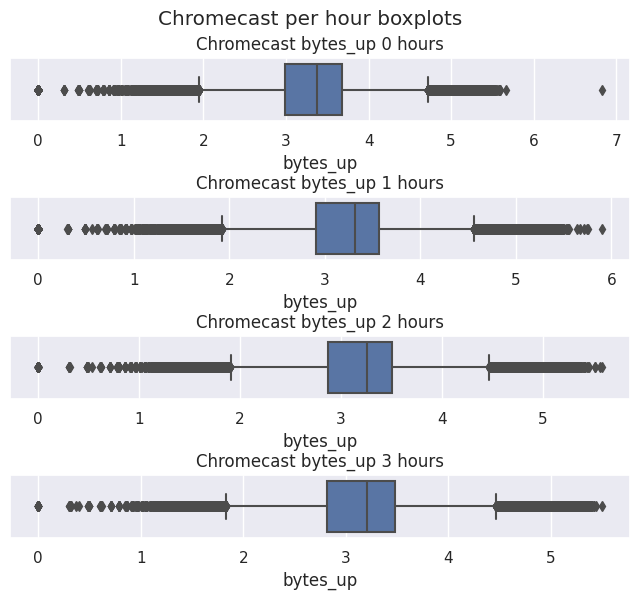

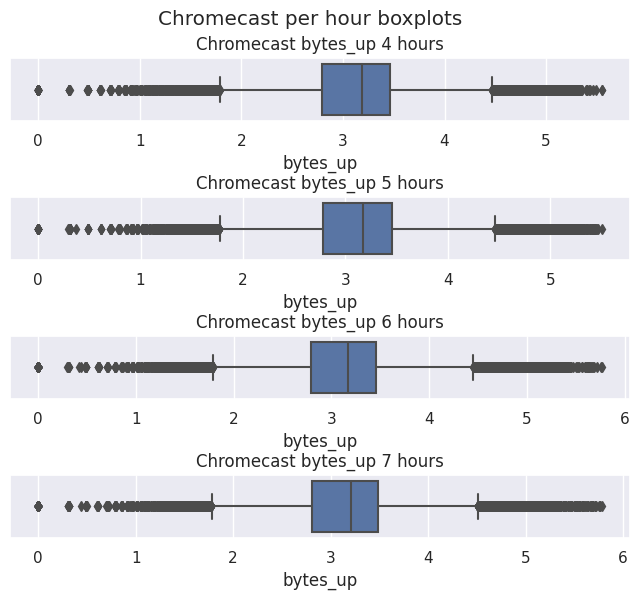

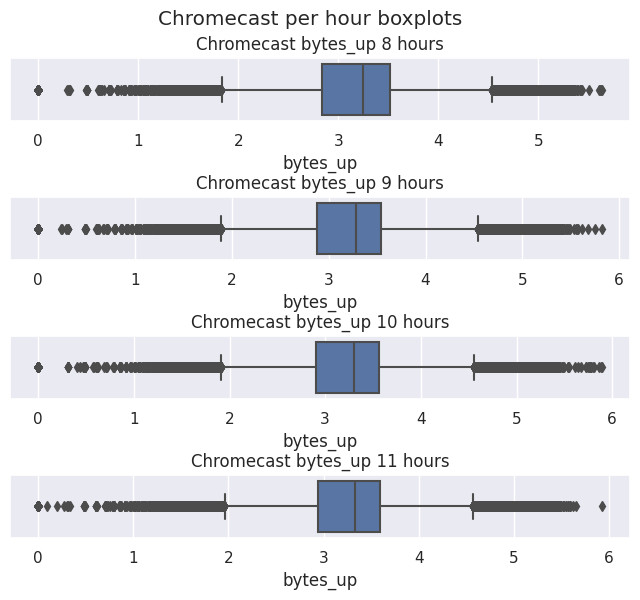

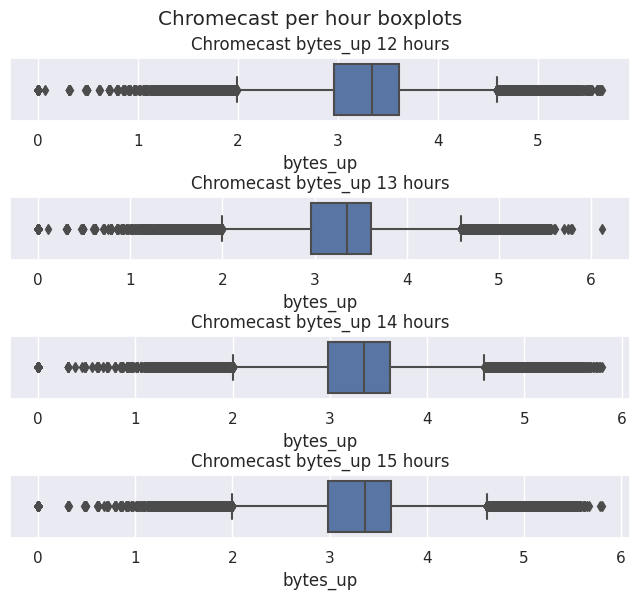

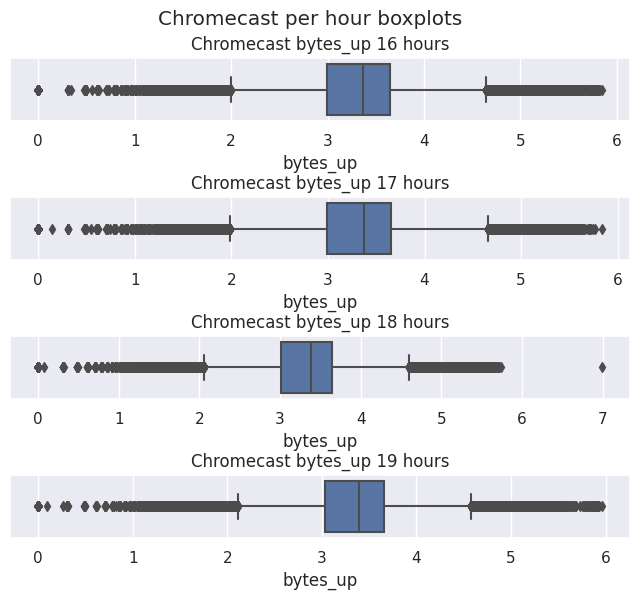

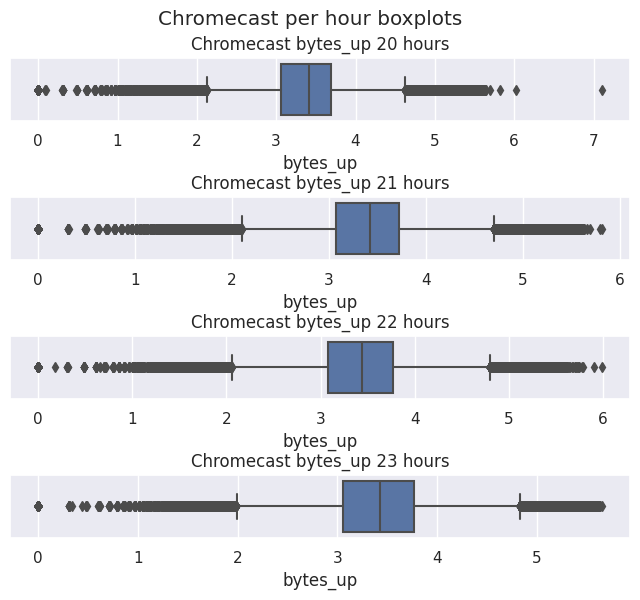

In [51]:
gen_per_time_boxplots(ds_chromecast_sliced, 'bytes_up', 'Chromecast')

#### Basic stats Chromecast bytes up

In [52]:
gen_per_time_basic_stats(ds_chromecast_sliced, 'bytes_up', 'Chromecast')

Chromecast bytes_up basic stats 0 hours
mean        3.432224
std_dev     0.794518
variance    0.631259
Name: bytes_up, dtype: float64


Chromecast bytes_up basic stats 1 hours
mean        3.322240
std_dev     0.694322
variance    0.482083
Name: bytes_up, dtype: float64


Chromecast bytes_up basic stats 2 hours
mean        3.243208
std_dev     0.584306
variance    0.341414
Name: bytes_up, dtype: float64


Chromecast bytes_up basic stats 3 hours
mean        3.202075
std_dev     0.554351
variance    0.307305
Name: bytes_up, dtype: float64


Chromecast bytes_up basic stats 4 hours
mean        3.178324
std_dev     0.560972
variance    0.314690
Name: bytes_up, dtype: float64


Chromecast bytes_up basic stats 5 hours
mean        3.159119
std_dev     0.539312
variance    0.290857
Name: bytes_up, dtype: float64


Chromecast bytes_up basic stats 6 hours
mean        3.156929
std_dev     0.551092
variance    0.303702
Name: bytes_up, dtype: float64


Chromecast bytes_up basic stats 7 hours
mean    

### Chromecast bytes down

#### Boxplots Chromecast bytes down

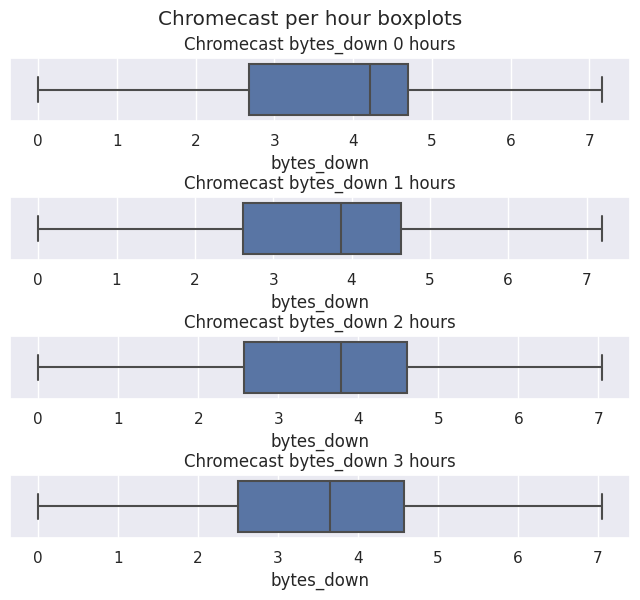

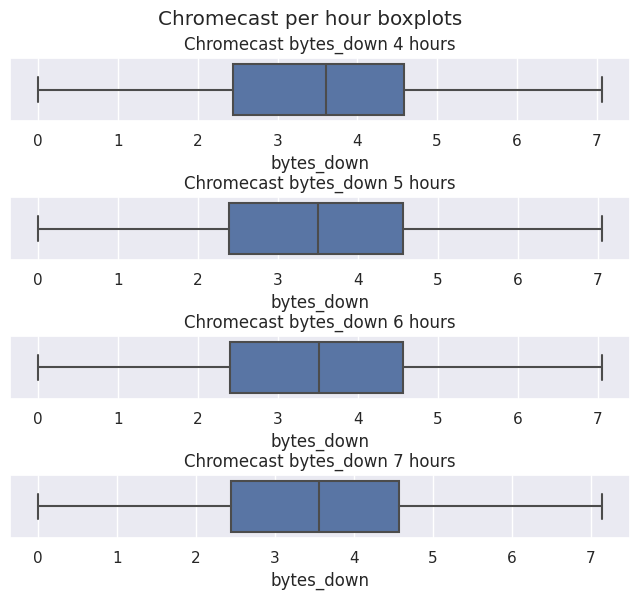

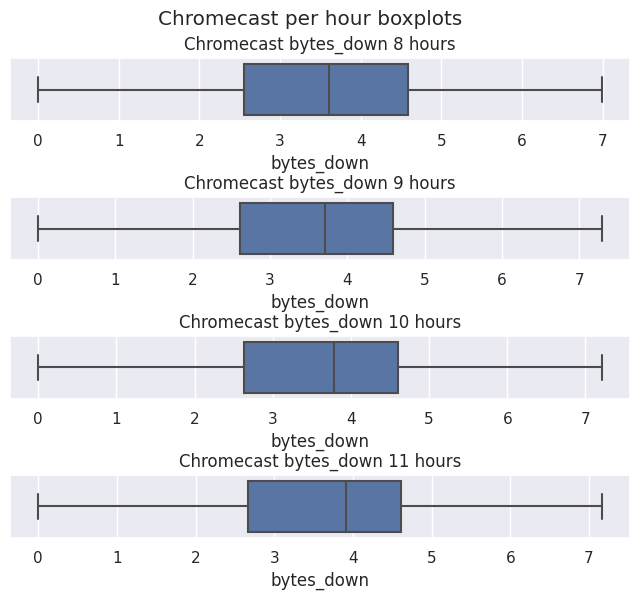

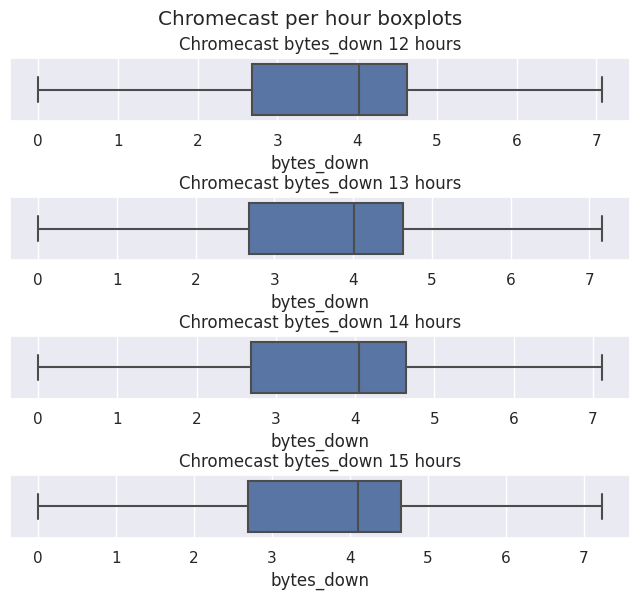

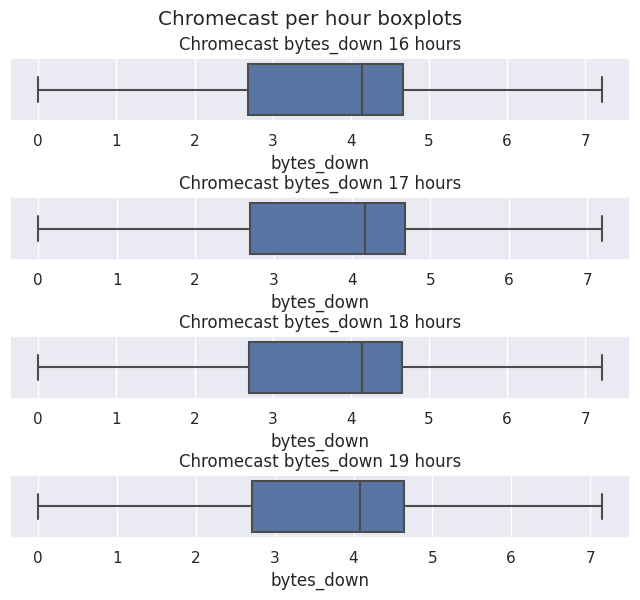

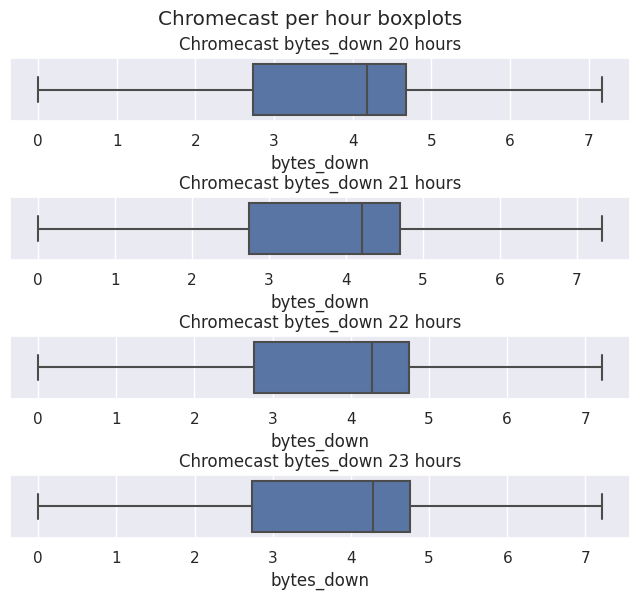

In [53]:
gen_per_time_boxplots(ds_chromecast_sliced, 'bytes_down', 'Chromecast')

#### Basic stats Chromecast bytes down

In [54]:
gen_per_time_basic_stats(ds_chromecast_sliced, 'bytes_down', 'Chromecast')

Chromecast bytes_down basic stats 0 hours
mean        3.952850
std_dev     1.436895
variance    2.064666
Name: bytes_down, dtype: float64


Chromecast bytes_down basic stats 1 hours
mean        3.775800
std_dev     1.319655
variance    1.741489
Name: bytes_down, dtype: float64


Chromecast bytes_down basic stats 2 hours
mean        3.685634
std_dev     1.207270
variance    1.457501
Name: bytes_down, dtype: float64


Chromecast bytes_down basic stats 3 hours
mean        3.636654
std_dev     1.186383
variance    1.407506
Name: bytes_down, dtype: float64


Chromecast bytes_down basic stats 4 hours
mean        3.618231
std_dev     1.189139
variance    1.414050
Name: bytes_down, dtype: float64


Chromecast bytes_down basic stats 5 hours
mean        3.571032
std_dev     1.173356
variance    1.376763
Name: bytes_down, dtype: float64


Chromecast bytes_down basic stats 6 hours
mean        3.565706
std_dev     1.170897
variance    1.371000
Name: bytes_down, dtype: float64


Chromecast bytes_dow

### Smart TV bytes up

#### Boxplots Smart TV bytes up

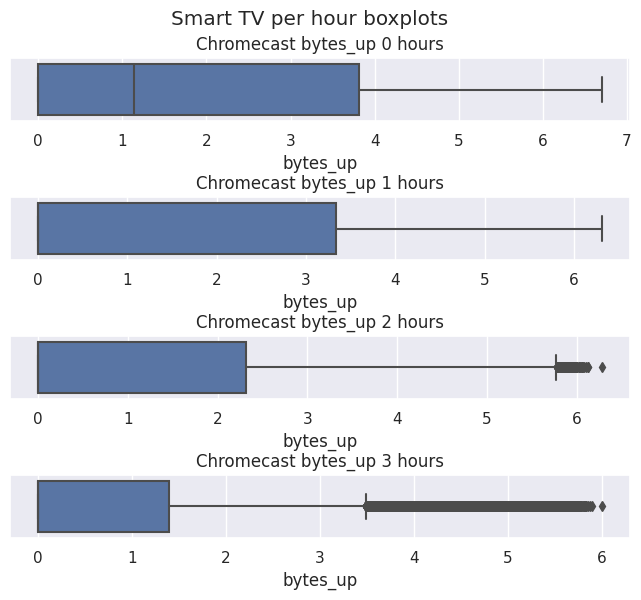

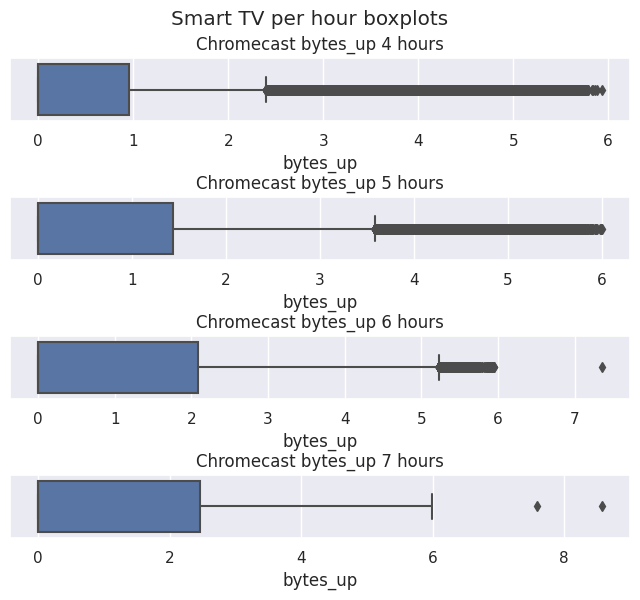

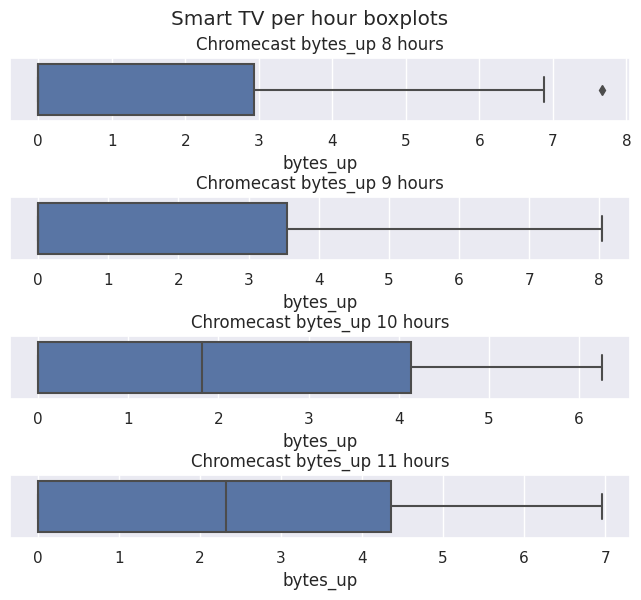

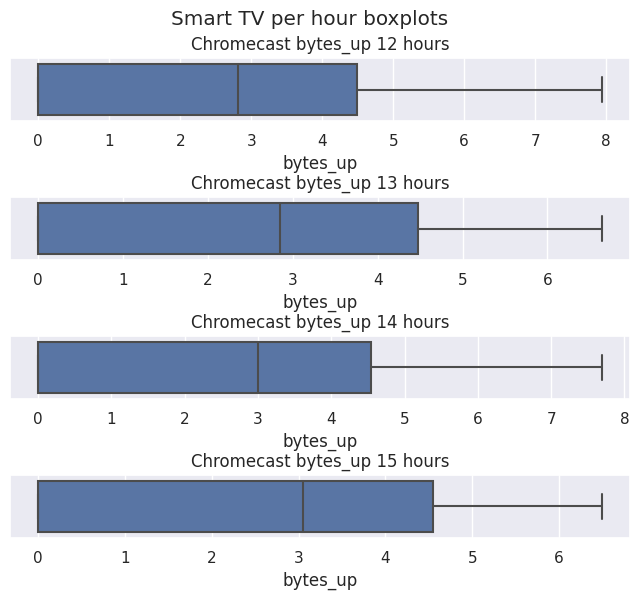

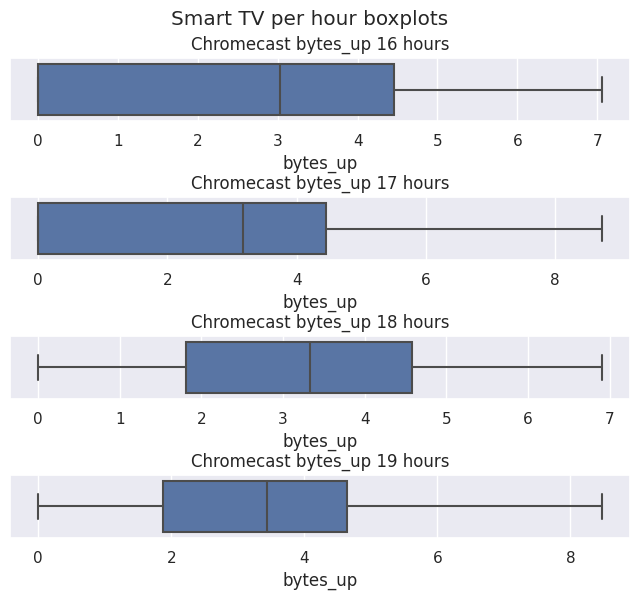

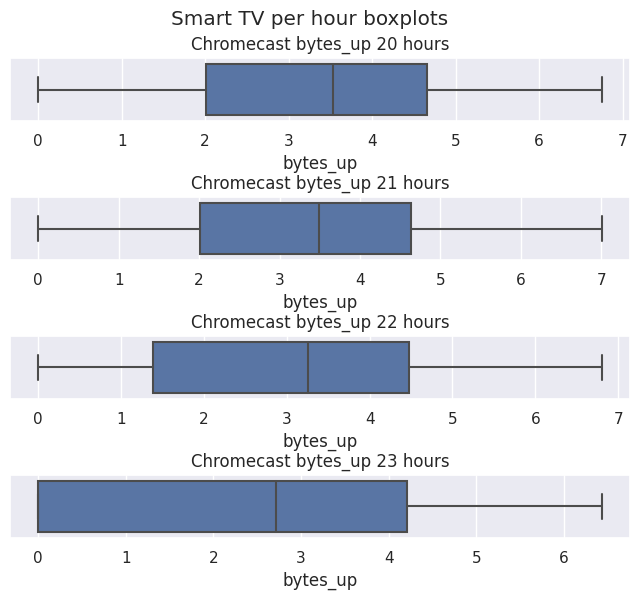

In [55]:
gen_per_time_boxplots(ds_smart_tv_sliced, 'bytes_up', 'Smart TV')

#### Basic stats Smart TV bytes up

In [56]:
gen_per_time_basic_stats(ds_smart_tv_sliced, 'bytes_up', 'Smart TV')

Smart TV bytes_up basic stats 0 hours
mean        1.894305
std_dev     2.038918
variance    4.157187
Name: bytes_up, dtype: float64


Smart TV bytes_up basic stats 1 hours
mean        1.467429
std_dev     1.938709
variance    3.758593
Name: bytes_up, dtype: float64


Smart TV bytes_up basic stats 2 hours
mean        1.153520
std_dev     1.775299
variance    3.151687
Name: bytes_up, dtype: float64


Smart TV bytes_up basic stats 3 hours
mean        0.893250
std_dev     1.569978
variance    2.464831
Name: bytes_up, dtype: float64


Smart TV bytes_up basic stats 4 hours
mean        0.768513
std_dev     1.433807
variance    2.055803
Name: bytes_up, dtype: float64


Smart TV bytes_up basic stats 5 hours
mean        0.875206
std_dev     1.531350
variance    2.345032
Name: bytes_up, dtype: float64


Smart TV bytes_up basic stats 6 hours
mean        1.024942
std_dev     1.624929
variance    2.640394
Name: bytes_up, dtype: float64


Smart TV bytes_up basic stats 7 hours
mean        1.197472
std

### Smart TV bytes down

#### Boxplots Smart TV bytes down

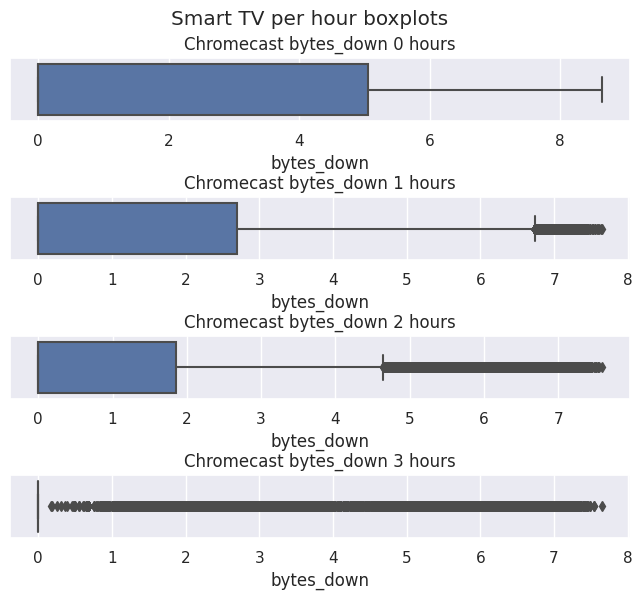

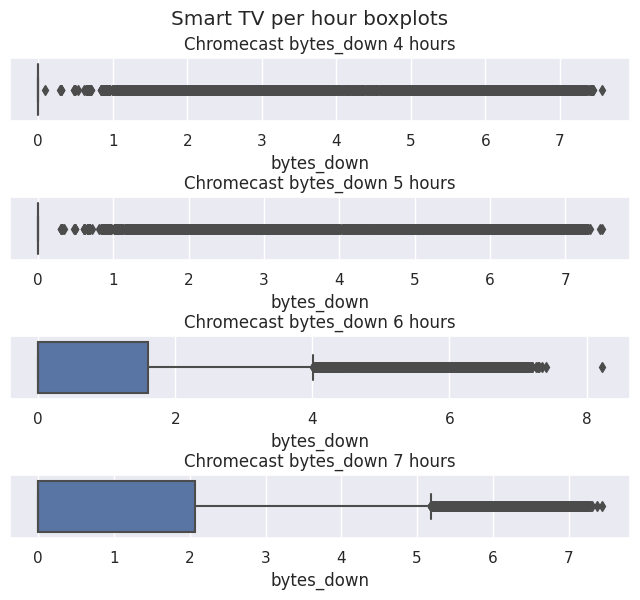

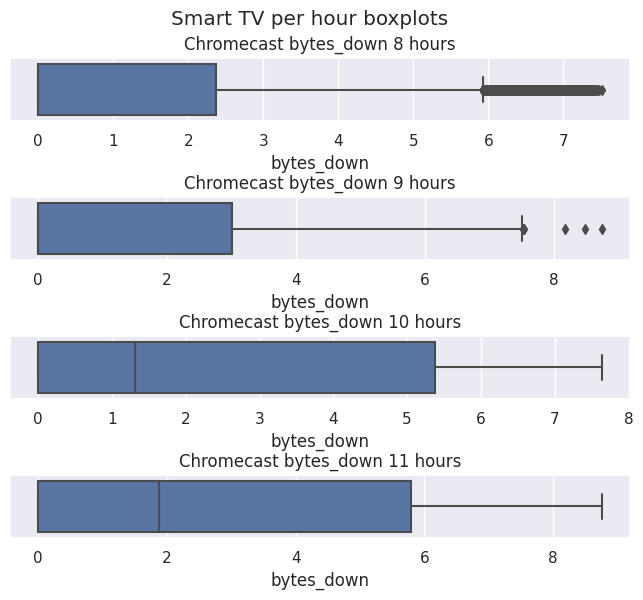

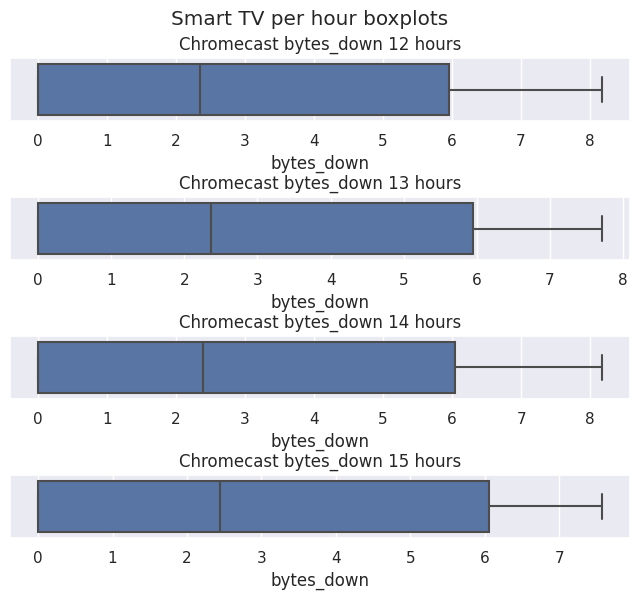

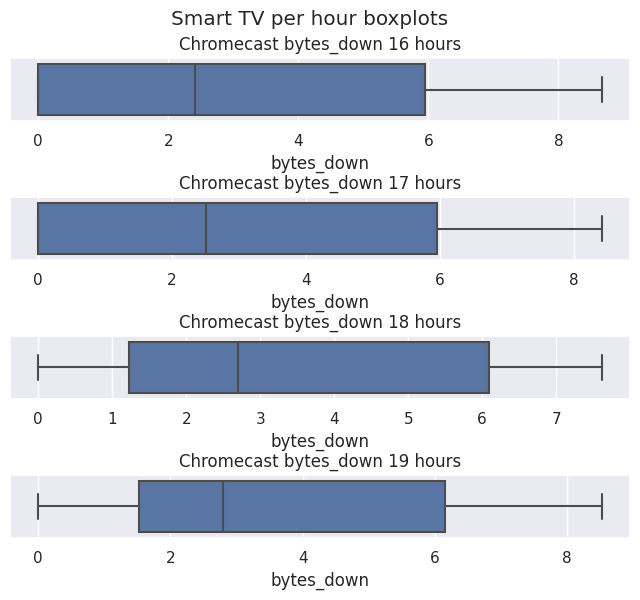

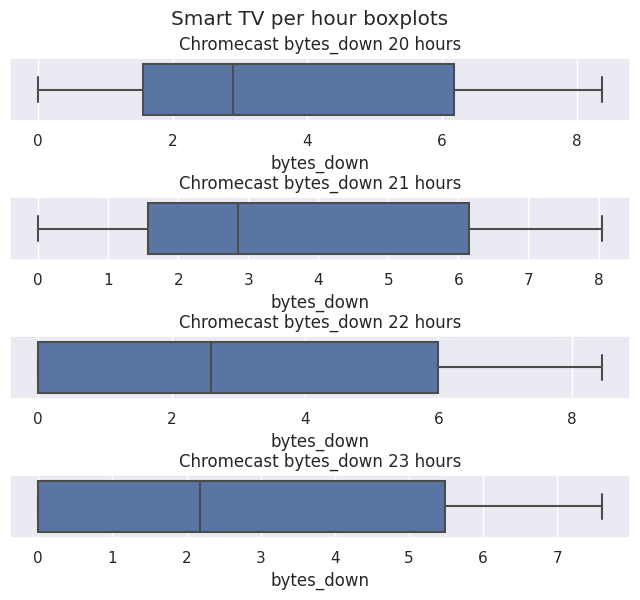

In [57]:
gen_per_time_boxplots(ds_smart_tv_sliced, 'bytes_down', 'Smart TV')

#### Basic stats Smart TV bytes down

In [58]:
gen_per_time_basic_stats(ds_smart_tv_sliced, 'bytes_down', 'Smart TV')

Smart TV bytes_down basic stats 0 hours
mean        2.104854
std_dev     2.624461
variance    6.887793
Name: bytes_down, dtype: float64


Smart TV bytes_down basic stats 1 hours
mean        1.601558
std_dev     2.460014
variance    6.051668
Name: bytes_down, dtype: float64


Smart TV bytes_down basic stats 2 hours
mean        1.228449
std_dev     2.226354
variance    4.956650
Name: bytes_down, dtype: float64


Smart TV bytes_down basic stats 3 hours
mean        0.897434
std_dev     1.904640
variance    3.627655
Name: bytes_down, dtype: float64


Smart TV bytes_down basic stats 4 hours
mean        0.735541
std_dev     1.699148
variance    2.887103
Name: bytes_down, dtype: float64


Smart TV bytes_down basic stats 5 hours
mean        0.891368
std_dev     1.876726
variance    3.522100
Name: bytes_down, dtype: float64


Smart TV bytes_down basic stats 6 hours
mean        1.072552
std_dev     1.999899
variance    3.999597
Name: bytes_down, dtype: float64


Smart TV bytes_down basic stats 7 

### Plotting mean, variance and standard deviation per hour

#### Preparing data

In [59]:
df_dict_chromecast_basic_stats = gen_df_dict_basic_stats(ds_chromecast_sliced)
df_dict_smart_tv_basic_stats = gen_df_dict_basic_stats(ds_smart_tv_sliced)

In [60]:
df_chromecast_basic_stats = gen_df_basic_stats(df_dict_chromecast_basic_stats)
df_smart_tv_basic_stats = gen_df_basic_stats(df_dict_smart_tv_basic_stats)

In [61]:
df_chromecast_basic_stats.head()

,bytes_up_mean,bytes_up_std_dev,bytes_up_var,bytes_down_mean,bytes_down_std_dev,bytes_down_var
0,3.432224,3.432224,11.780164,3.952850,3.952850,15.625023
1,3.322240,3.322240,11.037280,3.775800,3.775800,14.256668
2,3.243208,3.243208,10.518398,3.685634,3.685634,13.583902
3,3.202075,3.202075,10.253285,3.636654,3.636654,13.225249
4,3.178324,3.178324,10.101746,3.618231,3.618231,13.091599


#### Generating scatterplots

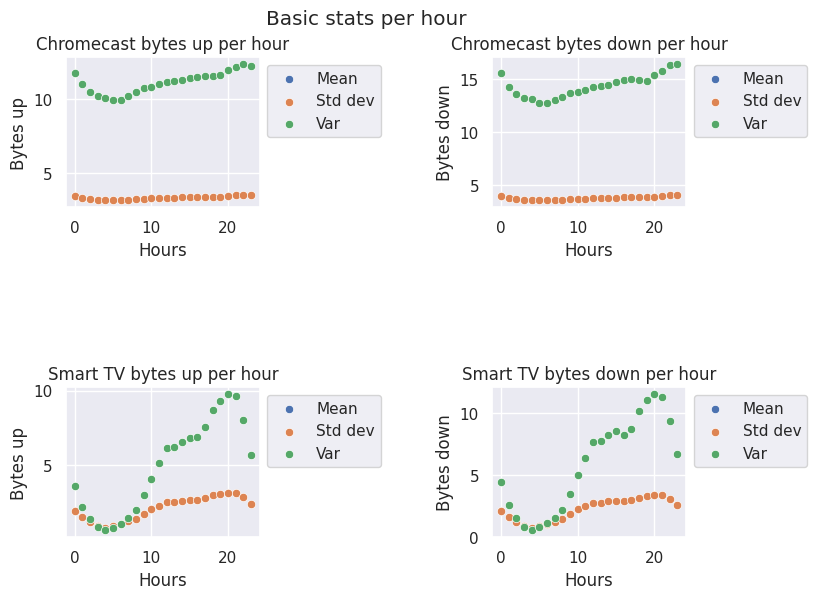

In [62]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, wspace=1.2, hspace=1.2)
fig.suptitle('Basic stats per hour')

hours = [i for i in range(0, 24)]
sns.scatterplot(df_chromecast_basic_stats, x=hours, y='bytes_up_mean', ax=axs[0,0])
sns.scatterplot(df_chromecast_basic_stats, x=hours, y='bytes_up_std_dev', ax=axs[0,0])
sns.scatterplot(df_chromecast_basic_stats, x=hours, y='bytes_up_var', ax=axs[0,0])
axs[0,0].set_title('Chromecast bytes up per hour')
axs[0,0].set_xlabel('Hours')
axs[0,0].set_ylabel('Bytes up')
axs[0,0].legend(['Mean', 'Std dev', 'Var'])
sns.move_legend(axs[0,0], "upper left", bbox_to_anchor=(1, 1))

sns.scatterplot(df_chromecast_basic_stats, x=hours, y='bytes_down_mean', ax=axs[0,1])
sns.scatterplot(df_chromecast_basic_stats, x=hours, y='bytes_down_std_dev', ax=axs[0,1])
sns.scatterplot(df_chromecast_basic_stats, x=hours, y='bytes_down_var', ax=axs[0,1])
axs[0,1].set_title('Chromecast bytes down per hour')
axs[0,1].set_xlabel('Hours')
axs[0,1].set_ylabel('Bytes down')
axs[0,1].legend(['Mean', 'Std dev', 'Var'])
sns.move_legend(axs[0,1], "upper left", bbox_to_anchor=(1, 1))

sns.scatterplot(df_smart_tv_basic_stats, x=hours, y='bytes_up_mean', ax=axs[1,0])
sns.scatterplot(df_smart_tv_basic_stats, x=hours, y='bytes_up_std_dev', ax=axs[1,0])
sns.scatterplot(df_smart_tv_basic_stats, x=hours, y='bytes_up_var', ax=axs[1,0])
axs[1,0].set_title('Smart TV bytes up per hour')
axs[1,0].set_xlabel('Hours')
axs[1,0].set_ylabel('Bytes up')
axs[1,0].legend(['Mean', 'Std dev', 'Var'])
sns.move_legend(axs[1,0], "upper left", bbox_to_anchor=(1, 1))

sns.scatterplot(df_smart_tv_basic_stats, x=hours, y='bytes_down_mean', ax=axs[1,1])
sns.scatterplot(df_smart_tv_basic_stats, x=hours, y='bytes_down_std_dev', ax=axs[1,1])
sns.scatterplot(df_smart_tv_basic_stats, x=hours, y='bytes_down_var', ax=axs[1,1])
axs[1,1].set_title('Smart TV bytes down per hour')
axs[1,1].set_xlabel('Hours')
axs[1,1].set_ylabel('Bytes down')
axs[1,1].legend(['Mean', 'Std dev', 'Var'])
sns.move_legend(axs[1,1], "upper left", bbox_to_anchor=(1, 1))

## 4. Characterizing the times with highest traffic value

### Step 1: Choosing datasets

#### Calculating medians and getting hours with two highest mean and median

In [63]:
extend_df_dict_with_median(ds_chromecast_sliced, df_dict_chromecast_basic_stats)
extend_df_dict_with_median(ds_smart_tv_sliced, df_dict_smart_tv_basic_stats)

In [64]:
chromecast_bytes_up_mean_hour, chromecast_bytes_down_mean_hour = hour_with_highest_mean(df_dict_chromecast_basic_stats)
chromecast_bytes_up_median_hour, chromecast_bytes_down_median_hour = hour_with_highest_median(df_dict_chromecast_basic_stats)

smart_tv_bytes_up_mean_hour, smart_tv_bytes_down_mean_hour = hour_with_highest_mean(df_dict_smart_tv_basic_stats)
smart_tv_bytes_up_median_hour, smart_tv_bytes_down_median_hour = hour_with_highest_median(df_dict_smart_tv_basic_stats)

#### Selecting the datasets

In [65]:
dataset_1 = ds_smart_tv_sliced[smart_tv_bytes_up_median_hour]
dataset_2 = ds_smart_tv_sliced[smart_tv_bytes_up_mean_hour]
dataset_3 = ds_smart_tv_sliced[smart_tv_bytes_down_median_hour]
dataset_4 = ds_smart_tv_sliced[smart_tv_bytes_down_mean_hour]

dataset_5 = ds_chromecast_sliced[chromecast_bytes_up_median_hour]
dataset_6 = ds_chromecast_sliced[chromecast_bytes_up_mean_hour]
dataset_7 = ds_chromecast_sliced[chromecast_bytes_down_median_hour]
dataset_8 = ds_chromecast_sliced[chromecast_bytes_down_mean_hour]

### Step 2: Plotting histograms for each dataset

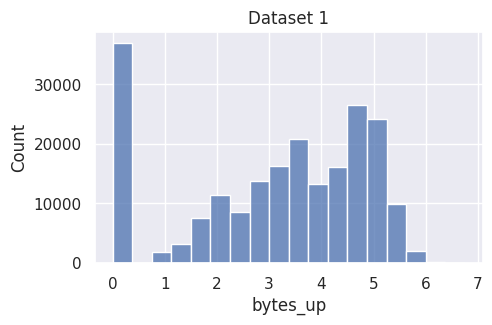

In [66]:
gen_histogram(dataset_1, 'bytes_up', 'Dataset 1')

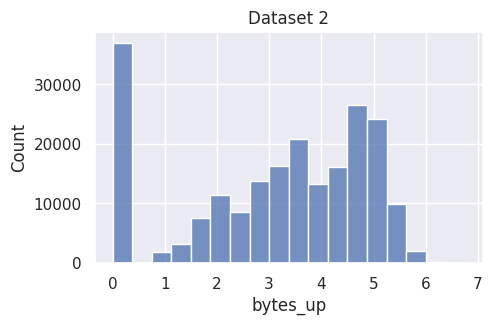

In [67]:
gen_histogram(dataset_2, 'bytes_up', 'Dataset 2')

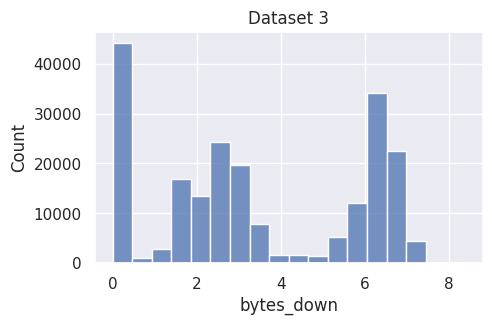

In [68]:
gen_histogram(dataset_3, 'bytes_down', 'Dataset 3')

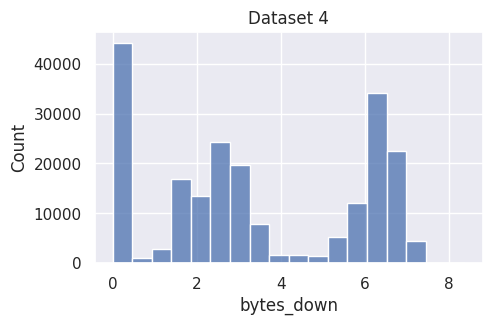

In [69]:
gen_histogram(dataset_4, 'bytes_down', 'Dataset 4')

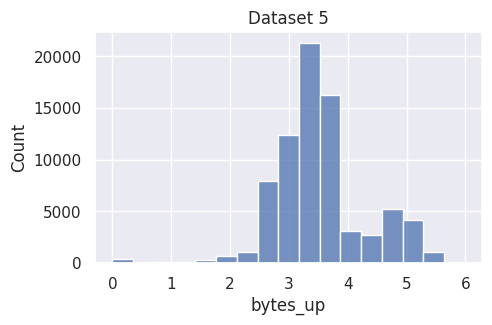

In [70]:
gen_histogram(dataset_5, 'bytes_up', 'Dataset 5')

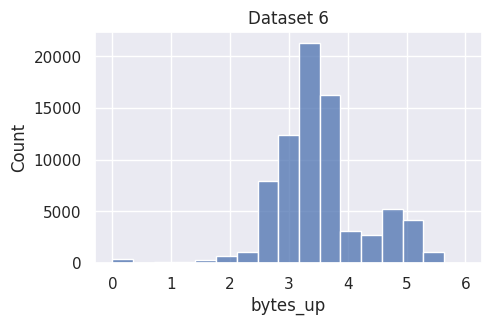

In [71]:
gen_histogram(dataset_6, 'bytes_up', 'Dataset 6')

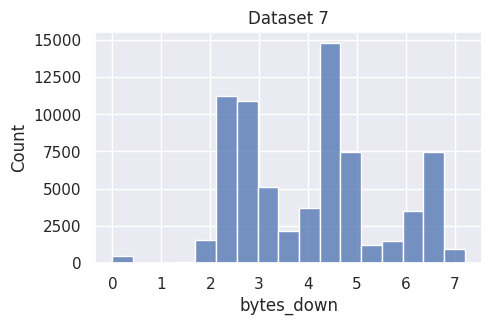

In [72]:
gen_histogram(dataset_7, 'bytes_down', 'Dataset 7')

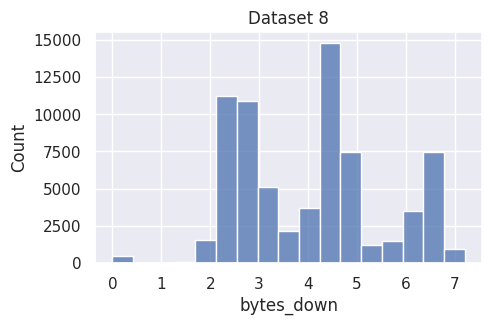

In [73]:
gen_histogram(dataset_8, 'bytes_down', 'Dataset 8')

### Step 3: Calculating MLE for gaussian and gamma distribution for each dataset

#### Calculating MLE for gaussian distribution

In [74]:
dfs = [
    dataset_1, dataset_2, dataset_3, dataset_4,
    dataset_5, dataset_6, dataset_7, dataset_8
]

In [75]:
dfs_gaussian_mle = calculate_mle_all_dfs(dfs, 'gaussian')

In [76]:
for i in range(1, len(dfs_gaussian_mle.values())+1):
    mu = dfs_gaussian_mle[i][0]
    sigma = dfs_gaussian_mle[i][1]
    print(f'Dataset {i}: mu = {mu}, sigma = {sigma}')

Dataset 1: mu = 3.124258107506722, sigma = 1.7800954110062503
Dataset 2: mu = 3.124258107506722, sigma = 1.7800954110062503
Dataset 3: mu = 3.3960945564366285, sigma = 2.490249669517658
Dataset 4: mu = 3.3960945564366285, sigma = 2.490249669517658
Dataset 5: mu = 3.521546370674634, sigma = 0.771823656417676
Dataset 6: mu = 3.521546370674634, sigma = 0.771823656417676
Dataset 7: mu = 4.052698112658847, sigma = 1.4694757963459488
Dataset 8: mu = 4.052698112658847, sigma = 1.4694757963459488


#### Calculating MLE for gamma distribution

In [77]:
dfs_gamma_mle = calculate_mle_all_dfs(dfs, 'gamma')

In [78]:
for i in range(1, len(dfs_gamma_mle.values())+1):
    shape = dfs_gamma_mle[i][0]
    loc = dfs_gamma_mle[i][1]
    scale = dfs_gamma_mle[i][2]
    print(f'Dataset {i}: shape = {shape}, loc = {loc}, scale = {scale}')

Dataset 1: shape = 217.14653644297584, loc = -23.859605776366315, scale = 0.12424488225923055
Dataset 2: shape = 217.14653644297584, loc = -23.859605776366315, scale = 0.12424488225923055
Dataset 3: shape = 896.5469322463027, loc = -71.06216506397283, scale = 0.08304989773768084
Dataset 4: shape = 896.5469322463027, loc = -71.06216506397283, scale = 0.08304989773768084
Dataset 5: shape = 3148.881521123096, loc = -39.808982624042514, scale = 0.013760617086978861
Dataset 6: shape = 3148.881521123096, loc = -39.808982624042514, scale = 0.013760617086978861
Dataset 7: shape = 27.130143662659037, loc = -3.6313681850617665, scale = 0.2832298335465073
Dataset 8: shape = 27.130143662659037, loc = -3.6313681850617665, scale = 0.2832298335465073


### Step 4: Plotting histogram, gaussian distribution and gamma distribution

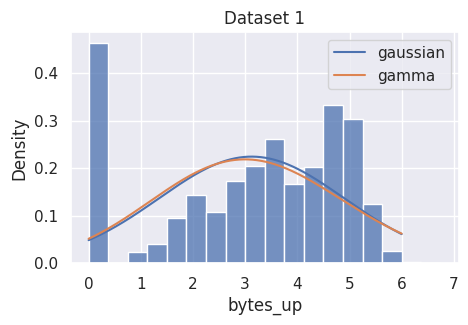

In [79]:
plotting_hist_mle_curves(dfs, dfs_gaussian_mle, dfs_gamma_mle, 1)

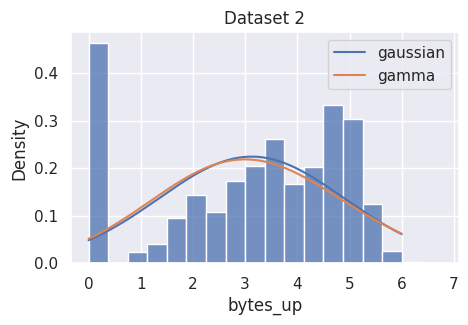

In [80]:
plotting_hist_mle_curves(dfs, dfs_gaussian_mle, dfs_gamma_mle, 2)

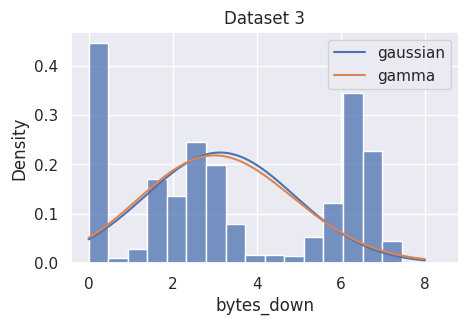

In [81]:
plotting_hist_mle_curves(dfs, dfs_gaussian_mle, dfs_gamma_mle, 3)

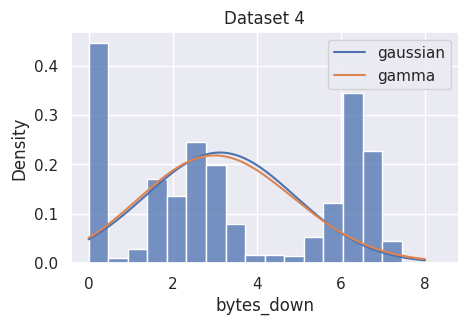

In [82]:
plotting_hist_mle_curves(dfs, dfs_gaussian_mle, dfs_gamma_mle, 4)

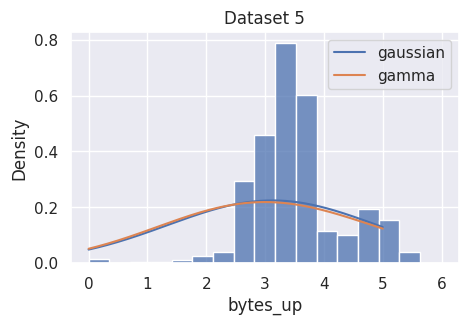

In [83]:
plotting_hist_mle_curves(dfs, dfs_gaussian_mle, dfs_gamma_mle, 5)

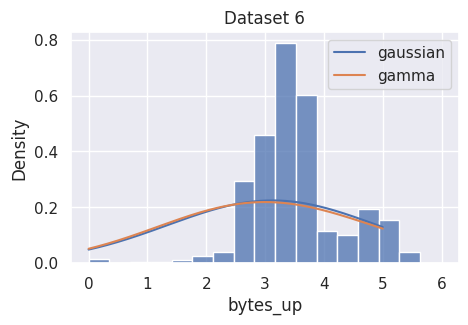

In [84]:
plotting_hist_mle_curves(dfs, dfs_gaussian_mle, dfs_gamma_mle, 6)

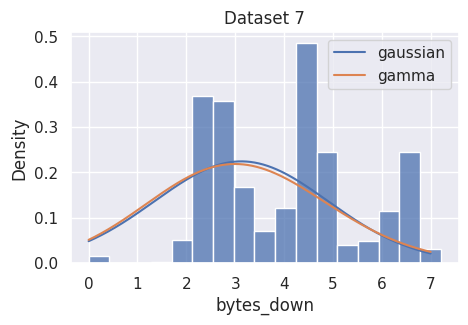

In [85]:
plotting_hist_mle_curves(dfs, dfs_gaussian_mle, dfs_gamma_mle, 7)

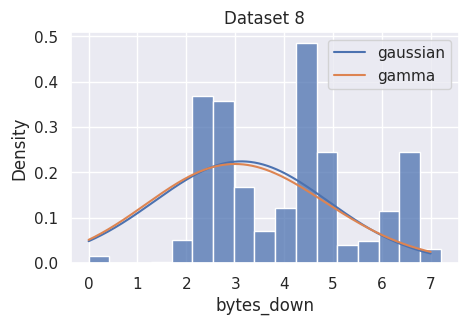

In [86]:
plotting_hist_mle_curves(dfs, dfs_gaussian_mle, dfs_gamma_mle, 8)

### Step 5: Plotting probability plots

#### Gaussian

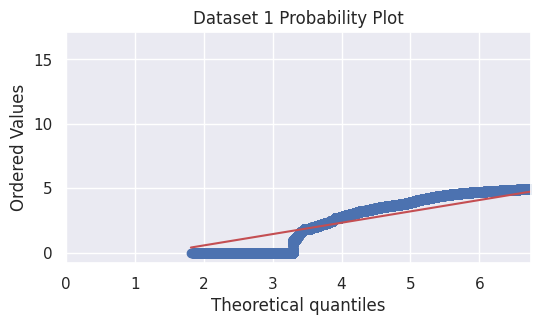

In [87]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 1)

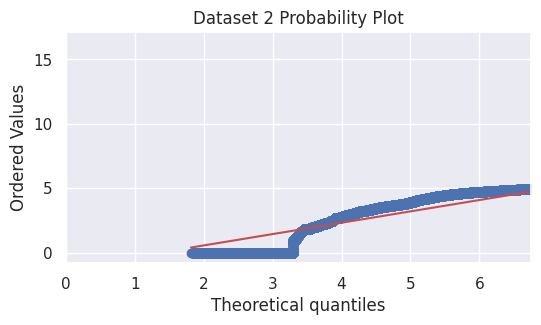

In [88]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 2)

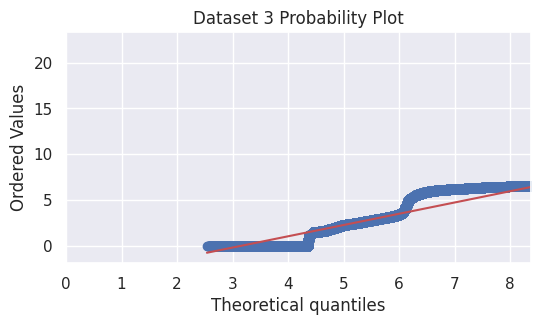

In [89]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 3)

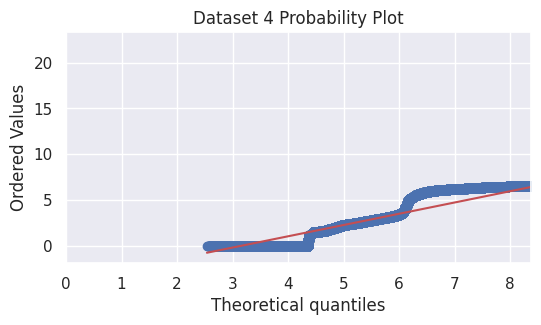

In [90]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 4)

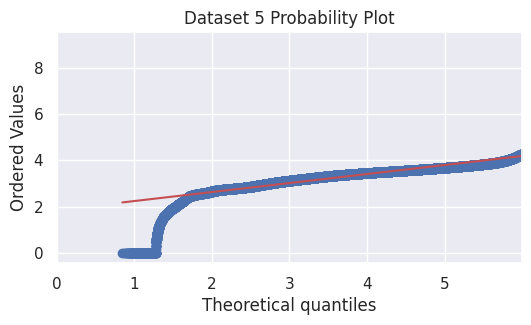

In [91]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 5)

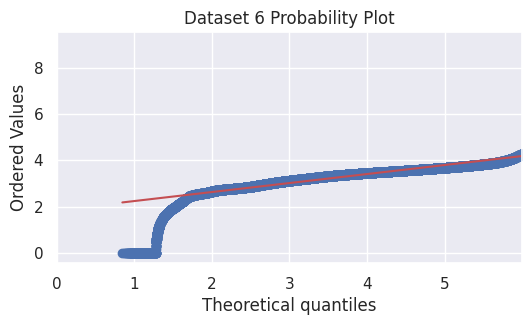

In [92]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 6)

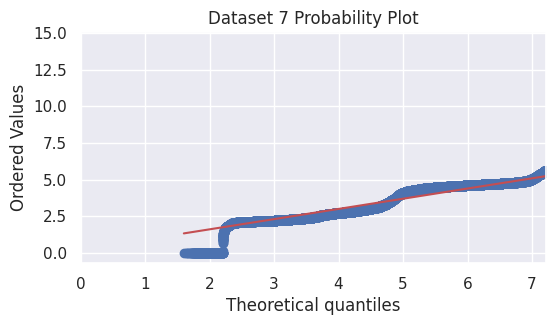

In [93]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 7)

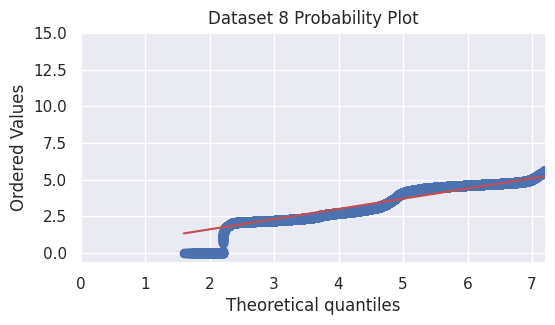

In [94]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 8)

#### Gamma

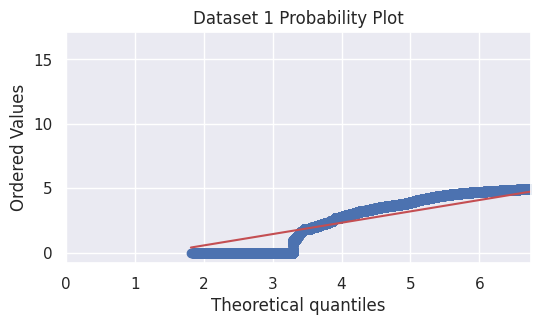

In [95]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 1)

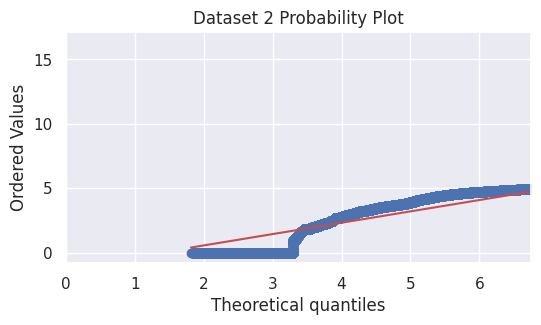

In [96]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 2)

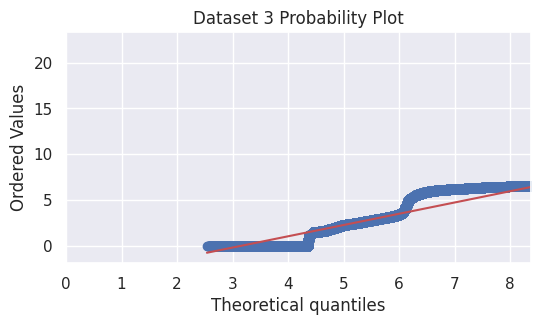

In [97]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 3)

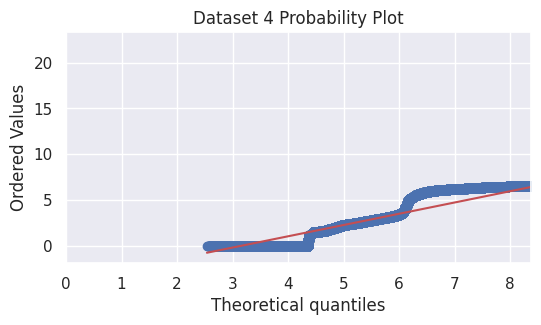

In [98]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 4)

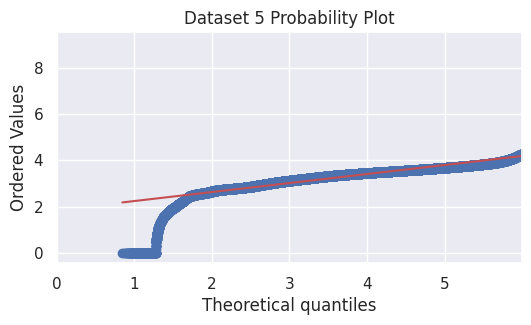

In [99]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 5)

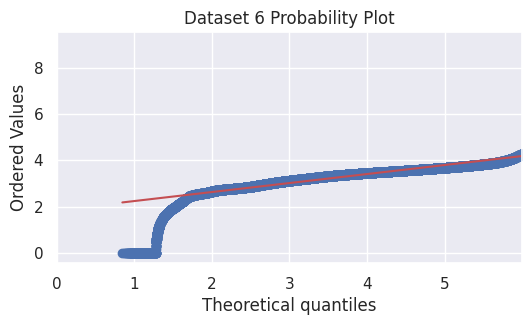

In [100]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 6)

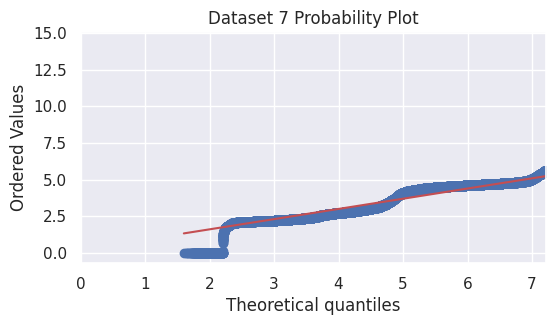

In [101]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 7)

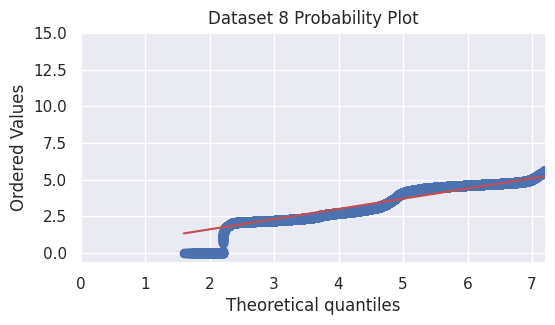

In [102]:
gen_probability_plot_mle(dfs, dfs_gaussian_mle, 8)

## 5. Análise da correlação entre as taxas de upload e download para os horários com o maior valor de tráfego

### Datasets 1 e 3

In [103]:
df1_mod, df3_mod = get_same_time_datasets(dataset_1, dataset_3, ds_smart_tv_sliced)
coef_13 = calculate_coefficient_correlation(df1_mod, df3_mod)
print(coef_13)

bytes_up      1.0
bytes_down    1.0
dtype: float64


Text(0, 0.5, 'Dataset 3 bytes down')

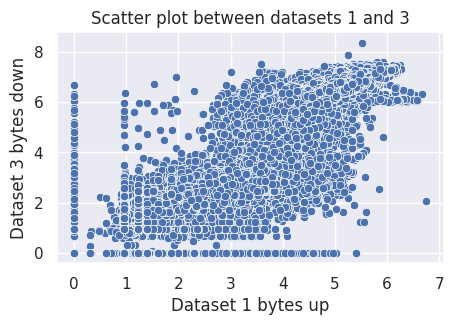

In [116]:
sns.scatterplot(x=df1_mod['bytes_up'], y=df3_mod['bytes_down'])
plt.title('Scatter plot between datasets 1 and 3')
plt.xlabel('Dataset 1 bytes up')
plt.ylabel('Dataset 3 bytes down')

### Datasets 2 e 4

In [104]:
df2_mod, df4_mod = get_same_time_datasets(dataset_2, dataset_4, ds_smart_tv_sliced)
coef_24 = calculate_coefficient_correlation(df2_mod, df4_mod)
print(coef_24)

bytes_up      1.0
bytes_down    1.0
dtype: float64


Text(0, 0.5, 'Dataset 4 bytes down')

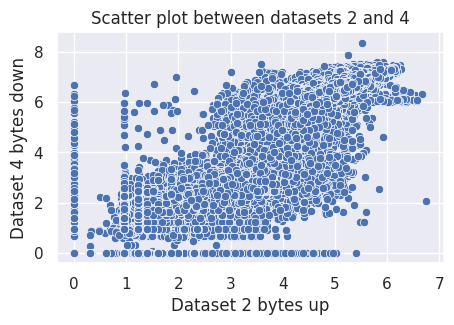

In [117]:
sns.scatterplot(x=df2_mod['bytes_up'], y=df4_mod['bytes_down'])
plt.title('Scatter plot between datasets 2 and 4')
plt.xlabel('Dataset 2 bytes up')
plt.ylabel('Dataset 4 bytes down')

### Datasets 5 e 7

In [105]:
df5_mod, df7_mod = get_same_time_datasets(dataset_5, dataset_7, ds_chromecast_sliced)
coef_57 = calculate_coefficient_correlation(df5_mod, df7_mod)
print(coef_57)

bytes_up      1.0
bytes_down    1.0
dtype: float64


Text(0, 0.5, 'Dataset 7 bytes down')

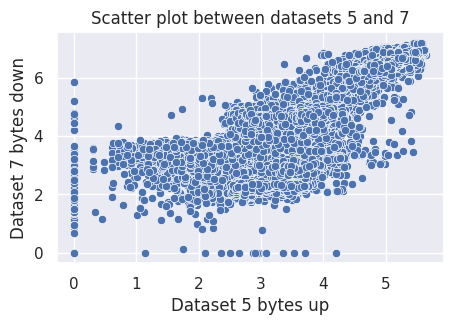

In [118]:
sns.scatterplot(x=df5_mod['bytes_up'], y=df7_mod['bytes_down'])
plt.title('Scatter plot between datasets 5 and 7')
plt.xlabel('Dataset 5 bytes up')
plt.ylabel('Dataset 7 bytes down')

### Datasets 6 e 8

In [106]:
df6_mod, df8_mod = get_same_time_datasets(dataset_6, dataset_8, ds_chromecast_sliced)
coef_68 = calculate_coefficient_correlation(df6_mod, df8_mod)
print(coef_68)

bytes_up      1.0
bytes_down    1.0
dtype: float64


Text(0, 0.5, 'Dataset 8 bytes down')

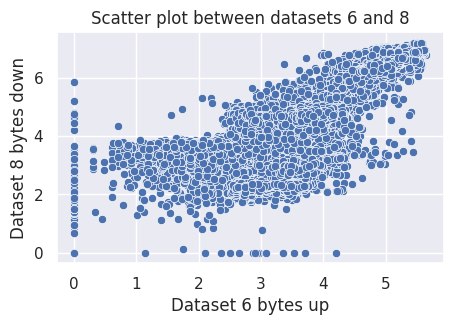

In [119]:
sns.scatterplot(x=df6_mod['bytes_up'], y=df8_mod['bytes_down'])
plt.title('Scatter plot between datasets 6 and 8')
plt.xlabel('Dataset 6 bytes up')
plt.ylabel('Dataset 8 bytes down')

## 6. Comparação dos dados gerados pelos dispositivos Smart-TV e Chromecast

In [121]:
G_values = dict()
p_values = dict()

### Datasets 1 e 5

In [122]:
hist1, hist5 = gen_g_test_histogram(dataset_1, dataset_5, 'bytes_up')

G, p_value = calculate_g_test(hist1, hist5)
print(G, p_value)

G_values['Datasets 1 and 5'] = G
p_values['Datasets 1 and 5'] = p_value

1.9663811066321155 0.9999969749616283


### Datasets 2 e 6

In [123]:
hist2, hist6 = gen_g_test_histogram(dataset_2, dataset_6, 'bytes_up')

G, p_value = calculate_g_test(hist2, hist6)
print(G, p_value)

G_values['Datasets 2 and 6'] = G
p_values['Datasets 2 and 6'] = p_value

1.9663811066321155 0.9999969749616283


### Datasets 3 e 7

In [124]:
hist3, hist7 = gen_g_test_histogram(dataset_3, dataset_7, 'bytes_down')

G, p_value = calculate_g_test(hist3, hist7)
print(G, p_value)

G_values['Datasets 3 and 7'] = G
p_values['Datasets 3 and 7'] = p_value

3.402469772833654 0.9998302046760069


### Datasets 4 e 8

In [125]:
hist4, hist8 = gen_g_test_histogram(dataset_4, dataset_8, 'bytes_down')

G, p_value = calculate_g_test(hist4, hist8)
print(G, p_value)

G_values['Datasets 4 and 8'] = G
p_values['Datasets 4 and 8'] = p_value

3.402469772833654 0.9998302046760069


### Table of G-test values and p-values

In [128]:
for key, value in G_values.items():
    print(str(key) + ' : ' + str(value))

Datasets 1 and 5 : 1.9663811066321155
Datasets 2 and 6 : 1.9663811066321155
Datasets 3 and 7 : 3.402469772833654
Datasets 4 and 8 : 3.402469772833654


In [129]:
for key, value in p_values.items():
    print(str(key) + ' : ' + str(value))

Datasets 1 and 5 : 0.9999969749616283
Datasets 2 and 6 : 0.9999969749616283
Datasets 3 and 7 : 0.9998302046760069
Datasets 4 and 8 : 0.9998302046760069


## Tail